In [1]:
# libraries
from transformers import pipeline
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



/Users/vickieknight/anaconda3/envs/info498b-final/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Basic statistics of corpus

Total number of inmates: 591

Timeframe associated with last statements:
Earliest statement: 1982-12-07 00:00:00
Latest statement: 2024-10-01 00:00:00

Race Demographics:
White: 263
Black: 211
Hispanic: 113
Other: 4

Age Statistics:
Average age: 40.2
Youngest: 24
Oldest: 78

Top Counties:
County
Harris     135
Dallas      65
Bexar       46
Tarrant     45
Nueces      17
Name: count, dtype: int64


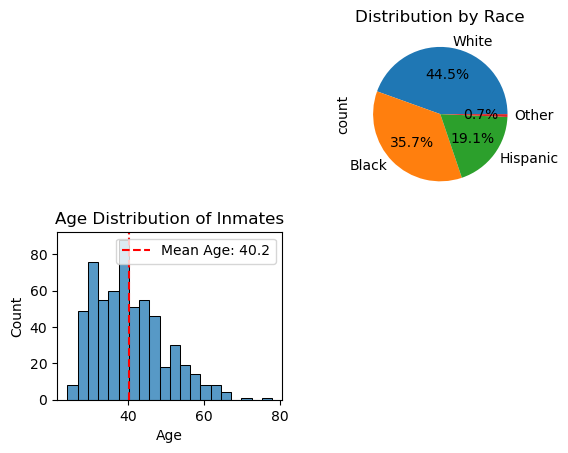

In [23]:
# load the dataset
deathrow_info = pd.read_csv('data/deathrow_info/executed_inmates.csv')

# number of inmates
total_inmates = len(deathrow_info)
print(f"Total number of inmates: {total_inmates}")

# the earliest and latest last statement
deathrow_info['Date'] = pd.to_datetime(deathrow_info['Date'])
earliest = deathrow_info['Date'].min()
latest = deathrow_info['Date'].max()

print(f"\nTimeframe associated with last statements:")
print(f"Earliest statement: {earliest}")
print(f"Latest statement: {latest}")

# race demographics
race_counts = deathrow_info['Race'].value_counts()

print("\nRace Demographics:")
for race, count in race_counts.items():
    print(f"{race}: {count}")

plt.subplot(2, 2, 2)
race_counts = deathrow_info['Race'].value_counts()
race_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution by Race')

# age statistics
age_mean = deathrow_info['Age'].mean()
age_min = deathrow_info['Age'].min()
age_max = deathrow_info['Age'].max()

print("\nAge Statistics:")
print(f"Average age: {age_mean:.1f}")
print(f"Youngest: {age_min}")
print(f"Oldest: {age_max}")

plt.subplot(2, 2, 3)
sns.histplot(data=deathrow_info, x='Age', bins=20)
plt.title('Age Distribution of Inmates')
plt.xlabel('Age')
plt.ylabel('Count')
plt.axvline(age_mean, color='r', linestyle='--', label=f'Mean Age: {age_mean:.1f}')
plt.legend()

# county statistics
county_counts = deathrow_info['County'].value_counts()
print("\nTop Counties:")
print(county_counts.head())

Cleaned up dataset:

In [2]:
# load the dataset
deathrow_info = pd.read_csv('data/deathrow_info/executed_inmates.csv')

# filter out any variation of "no statement"
def is_valid_statement(statement):
    no_statement_phrases = [
        'no last statement given.',
        'no statement was made.',
        'no statement given.',
        'none',
        'no statement',
        'no last statement.',
        'this inmate declined to make a last statement.',
        'no, i have no final statement.'
    ]
    
    clean_statement = str(statement).lower().strip()
    return clean_statement not in no_statement_phrases

clean_df = deathrow_info[deathrow_info['Last Statement'].apply(is_valid_statement)]

clean_df.loc[:, 'Last Statement'] = clean_df['Last Statement'].fillna("").astype(str)

# update the total number of inmates
total_inmates = len(clean_df)
print(f"Total number of inmates with statements: {total_inmates}")

Total number of inmates with statements: 474


### spaCy entity extraction (NER)

In [26]:
import spacy

# load a spacy model trained on web text
nlp_web = spacy.load("en_core_web_sm")

In [27]:
# Method to extract entities from text
def extract_entities(text):
    processed_doc = nlp_web(text)
    entities = [(ent.text, ent.label_) for ent in processed_doc.ents]
    return entities

# Entity column
clean_df['entities'] = clean_df['Last Statement'].apply(extract_entities)

display(clean_df['entities'].head())

/var/folders/mt/c_88523n41z85rl9zwh25cr40000gn/T/ipykernel_24811/783020694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['entities'] = clean_df['Last Statement'].apply(extract_entities)


0    [(Edwards, PERSON), (one, CARDINAL), (Warden, ...
1    [(Warden, GPE), (Pat, PERSON), (Death Row, PER...
2                     [(27,27, CARDINAL), (Bird, ORG)]
3    [(the Townsend Family, ORG), (one day, DATE), ...
4    [(Kitchens, PERSON), (James and Amy, PERSON), ...
Name: entities, dtype: object

In [28]:
from collections import defaultdict
from collections import Counter

In [29]:
# SpaCy NER extraction for general interest, but no additional analysis is focused here

# Flattened list of last column entities (span, entity)
entities_list = [(span, entity_type) for doc_entities in clean_df['entities'] for span, entity_type in doc_entities]

entity_type_counters = defaultdict(Counter)

# Most common span for each ent type
entities_common_span = {}

# Count (span, entity_type)
for span, entity_type in entities_list:
    entity_type_counters[entity_type][span] += 1

# Get most common span for each entity type
for entity_type, counter in entity_type_counters.items():
    most_common_span = counter.most_common(1)[0]
    entities_common_span[entity_type] = most_common_span

for entity_type, (span, count) in entities_common_span.items():
    print("Most common span for " + entity_type + ": " + span + " (" + str(count) + ")")

Most common span for PERSON: Jesus (84)
Most common span for CARDINAL: one (21)
Most common span for GPE: Warden (94)
Most common span for WORK_OF_ART: Love (13)
Most common span for ORG: the State of Texas (6)
Most common span for DATE: today (36)
Most common span for ORDINAL: First (28)
Most common span for LOC: earth (3)
Most common span for TIME: tonight (30)
Most common span for NORP: Spanish (9)
Most common span for MONEY: five Dollars (1)
Most common span for EVENT: Holy Week (1)
Most common span for FAC: the Thomas Family (1)
Most common span for PRODUCT: Carol (1)
Most common span for LANGUAGE: English (6)
Most common span for LAW: Hart and Eloise (1)
Most common span for QUANTITY: 180 pounds (1)


In [30]:
from sentence_transformers import SentenceTransformer

In [31]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [32]:
# SBERT embeddings

embeddings = []

for statement in clean_df['Last Statement']:
    embedding = model.encode(statement)
    embeddings.append(embedding)

clean_df['sbert_embedding'] = embeddings

/var/folders/mt/c_88523n41z85rl9zwh25cr40000gn/T/ipykernel_24811/3202395367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['sbert_embedding'] = embeddings


In [36]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [39]:
from datasets import load_dataset
import evaluate
import numpy as np
from transformers import AutoTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [46]:
# fine-tune BERT on SST-2 dataset

sst = load_dataset("glue", "sst2")

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# tokenize and truncate to 512 token limit for BERT
def preprocess_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_sst = sst.map(preprocess_function, batched=True)

# P/R/A metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="sst_classification_model", 
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_sst["train"],
    eval_dataset=tokenized_sst["validation"],
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

In [ ]:
# before training (on validation set)

evaluation_results = trainer.evaluate()

print(evaluation_results)

In [ ]:
# trainer.train()

In [ ]:
# Load saved trained binary classif model
model = AutoModelForSequenceClassification.from_pretrained("sst_classif_model")

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_sst["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics

In [ ]:
# after training (on validation set)

eval_results = trainer.evaluate()

print(eval_results)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Classification report for evaluation on validation set

predictions = trainer.predict(tokenized_sst["validation"])

logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

classif_report = classification_report(y_true, y_pred)

print(classif_report)

In [ ]:
# Confusion matrix graph for evaluation

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix for SST-2 Sentiment Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [ ]:
# Use binary classif model to predict sentiment for last statements, and count the distribution

clean_df = clean_df.reset_index(drop=True) # reset indices after dropping non-existing statements

tokenized_statements = clean_df["Last Statement"].apply(lambda x: preprocess_function({"sentence": x}))

statement_predictions = trainer.predict(tokenized_statements)
predicted_statement_labels = np.argmax(statement_predictions.predictions, axis=-1)

clean_df["Sentiment Label"] = predicted_statement_labels
clean_df["Sentiment Label"] = clean_df["Sentiment Label"].map(id2label)

sentiment_counts = Counter(clean_df["Sentiment Label"])

print("Sentiment Label Counts:")
for label, count in sentiment_counts.items():
    print(f"{label}: {count}")

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Graph scatterplot of SBERT embeddings along with pos/neg sentiment labeling

clean_df_copy = clean_df.copy()

embeddings_array = np.array(embeddings)

scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings_array)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings_normalized)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings_normalized)

clean_df_copy['Cluster'] = kmeans_labels

clean_df_copy['Year'] = clean_df_copy['Date'].str[-4:]

fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=clean_df_copy['Cluster'],
                 hover_data=[clean_df_copy['Year'], clean_df_copy['Race'], clean_df_copy['Age'],
                             clean_df_copy['County'], clean_df_copy["Sentiment Label"]])

fig.update_layout(title="Clustered Inmate Last Statements", 
                  xaxis_title="PCA 1", 
                  yaxis_title="PCA 2")

# fig.write_html("clustered_plot_3.html")

In [ ]:
# Graph SBERT embeddings and pos/neg sentiment labeling with **K-Means clustering**

# Normalize embeddings
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(np.array(embeddings))

# Reduce dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings_normalized)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings_normalized)

# Add clusters and extract year
clean_df_copy['Cluster'] = kmeans_labels
clean_df_copy['Year'] = clean_df_copy['Date'].str[-4:]

# Scatterplot with sentiment integration
fig = px.scatter(
    clean_df_copy,  # Ensure that the DataFrame is passed here
    x=X_pca[:, 0], y=X_pca[:, 1],
    color='Cluster',  # Cluster determines color
    symbol='Sentiment Label',  # Sentiment (binary) determines symbol shape
    hover_data=['Year', 'Race', 'Age', 'County', 'Sentiment Label', 'Last Statement'],
    labels={'x': 'PCA 1', 'y': 'PCA 2', 'color': 'Cluster', 'symbol': 'Sentiment'}
)

fig.update_layout(
    title="Clustered Inmate Last Statements with Sentiment",
    xaxis_title="PCA 1",
    yaxis_title="PCA 2",
    legend=dict(
        x=1.15,
        y=0.7,
        font=dict(size=14)
    )
)

# fig.write_html("clustered_plot_3_sentiment.html")

fig.show()


In [ ]:
# Cluster analytics by race, age, county, year, and binary sentiment label
for cluster in clean_df_copy['Cluster'].unique():
    cluster_data = clean_df_copy[clean_df_copy['Cluster'] == cluster]
    total_count = len(cluster_data)  # Total rows in the cluster
    
    print(f"\n--- Cluster {cluster} ---")
    print(f"Total Count: {total_count}\n")
    
    # Race distribution
    print("\nRace Distribution:")
    race_counts = clean_df_copy[clean_df_copy['Cluster'] == cluster]['Race'].value_counts()
    for race, count in race_counts.items():
        percentage = (count / len(clean_df_copy[clean_df_copy['Cluster'] == cluster])) * 100
        print(f"{race}: {count} ({percentage:.2f}%)")
    
    # Age distribution
    print("\nAge Distribution:")
    age_counts = clean_df_copy[clean_df_copy['Cluster'] == cluster]['Age'].value_counts()
    for age, count in age_counts.items():
        percentage = (count / len(clean_df_copy[clean_df_copy['Cluster'] == cluster])) * 100
        print(f"{age}: {count} ({percentage:.2f}%)")
    
    # County distribution
    print("\nCounty Distribution:")
    county_counts = clean_df_copy[clean_df_copy['Cluster'] == cluster]['County'].value_counts()
    for county, count in county_counts.items():
        percentage = (count / len(clean_df_copy[clean_df_copy['Cluster'] == cluster])) * 100
        print(f"{county}: {count} ({percentage:.2f}%)")
    
    # Year distribution
    print("\nYear Distribution:")
    year_counts = clean_df_copy[clean_df_copy['Cluster'] == cluster]['Year'].value_counts()
    for year, count in year_counts.items():
        percentage = (count / len(clean_df_copy[clean_df_copy['Cluster'] == cluster])) * 100
        print(f"{year}: {count} ({percentage:.2f}%)")

    # Sentiment label distribution
    print("\nSentiment Label Distribution:")
    sentiment_counts = clean_df_copy[clean_df_copy['Cluster'] == cluster]['Sentiment Label'].value_counts()
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(clean_df_copy[clean_df_copy['Cluster'] == cluster])) * 100
        print(f"{sentiment}: {count} ({percentage:.2f}%)")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Plot cluster distribution by race

plt.figure(figsize=(20, 10))

# Race distribution
plt.subplot(2, 2, 1)
sns.countplot(x='Race', hue='Cluster', data=clean_df_copy)
plt.title('Race Distribution by Cluster')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Plot year distribution by cluster
plt.figure(figsize=(20, 10))
sns.countplot(x='Year', hue='Cluster', data=clean_df_copy)
plt.title('Year Distribution by Cluster')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# overall sentiment distribution
plt.figure(figsize=(8, 6))

sns.countplot(x='Sentiment Label', data=clean_df_copy, palette='coolwarm', hue=None)

plt.title('Total Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 8))

# group clusters and sentiment labels
sentiment_cluster_counts = clean_df_copy.groupby(['Cluster', 'Sentiment Label']).size().unstack(fill_value=0)

# stacked bar chart
sentiment_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

plt.title('Sentiment Label Distribution Across Clusters (Counts)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Label')

plt.tight_layout()
plt.show()

In [ ]:
sentiment_heatmap = clean_df_copy.pivot_table(
    index='Cluster', columns='Sentiment Label', values='Last Statement', aggfunc='count'
).fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_heatmap, cmap='RdBu', annot=True, fmt='g')
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Sentiment')
plt.ylabel('Cluster')
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
representative_statements = []

for cluster in clean_df_copy['Cluster'].unique():
    # get indices of statements for each cluster
    cluster_indices = clean_df_copy[clean_df_copy['Cluster'] == cluster].index
    cluster_embeddings = embeddings_array[cluster_indices]
    cluster_statements = clean_df_copy.loc[cluster_indices, 'Last Statement']

    # centroid for the current cluster
    centroid = np.mean(cluster_embeddings, axis=0)

    # cosine similarity between the centroid and each statement embedding
    similarities = cosine_similarity([centroid], cluster_embeddings).flatten()

    # find statement with highest cos similarity to the centroid
    most_representative_idx = np.argmax(similarities)
    most_representative_statement = cluster_statements.iloc[most_representative_idx]

    representative_statements.append((cluster, most_representative_statement))

for cluster, statement in representative_statements:
    print(f"Cluster {cluster}: {statement}")
    print()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
cluster_texts = clean_df_copy.groupby('Cluster')['Last Statement'].apply(lambda x: ' '.join(x))

# compute TF-IDF scores
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(cluster_texts)
terms = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=cluster_texts.index, columns=terms)

# Extract the top 20 terms for each cluster
for cluster in tfidf_df.index:
    top_terms = tfidf_df.loc[cluster].nlargest(20)
    plt.figure(figsize=(10, 8))
    
    top_terms.sort_values().plot(kind='barh', color=sns.color_palette("Blues", n_colors=20)[-1])  
    
    plt.title(f'Top TF-IDF Terms for Cluster {cluster}')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Terms')
    plt.tight_layout()
    plt.show()

### Find the different kinds of sentiments using BERT embeddings and GPT-2

In [4]:
# process last statements with pretrained BERT emotion classification
def analyze_emotions_bert(df):
    classifier = pipeline(
        "text-classification",
        model='bhadresh-savani/bert-base-uncased-emotion', 
        return_all_scores=True,
        truncation=True,  
        max_length=512)
    
    all_emotions = []

    for statement in tqdm(df['Last Statement'], desc="Analyze statements"):
        result = classifier(str(statement))[0]
        emotion_scores = {pred['label']: pred['score'] for pred in result}

        all_emotions.append(emotion_scores)

    
    # create emotion dataframe 
    emotions_df = pd.DataFrame(all_emotions)

    emotions_df['dominant_emotion'] = emotions_df[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].idxmax(axis=1)

    result_df = pd.concat([df, emotions_df], axis=1)

    return result_df

def process_deathrow_statements(df):
    results = analyze_emotions_bert(df)

    return results


# process the statements
df = clean_df
results = process_deathrow_statements(df)

# basic analysis
print("\nEmotion Distribution:")
print(results['dominant_emotion'].value_counts())

# average emotion scores
print("\nAverage Emotion Scores:")
print(results[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].mean())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/vickieknight/anaconda3/envs/info498b-final/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analyze statements: 100%|██████████| 474/474 [00:52<00:00,  9.05it/s]


Emotion Distribution:
dominant_emotion
joy         297
sadness     108
anger        36
love         29
fear          3
surprise      1
Name: count, dtype: int64

Average Emotion Scores:
sadness     0.224083
joy         0.574378
love        0.111249
anger       0.078298
fear        0.009288
surprise    0.002703
dtype: float64


In [5]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def analyze_emotions_gpt(df):
    tokenizer = AutoTokenizer.from_pretrained("heegyu/gpt2-emotion")
    model = AutoModelForCausalLM.from_pretrained("heegyu/gpt2-emotion")
    classifier = pipeline(
        "text-generation",
        tokenizer=tokenizer,
        model=model,
        device=0  
    )
    
    all_emotions = []
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    for statement in tqdm(df['Last Statement'], desc="Analyzing emotions"):
        try:
            input_text = tokenizer.decode(tokenizer.encode(statement, max_length=50, truncation=True))
            result = classifier(input_text, max_length=100, num_return_sequences=1)
            
            emotion_dict = {emotion: 0 for emotion in emotion_labels}
            generated_text = result[0]['generated_text'].lower()
            for emotion in emotion_labels:
                if emotion in generated_text:
                    emotion_dict[emotion] = generated_text.count(emotion) / len(generated_text)
            
            total_score = sum(emotion_dict.values())
            if total_score > 0:
                emotion_dict = {k: v / total_score for k, v in emotion_dict.items()}
            else:
                emotion_dict['other_emotions'] = 1.0
        except Exception as e:
            print(f"Error processing statement: {e}")
            emotion_dict = {'error': 1.0, 'other_emotions': 0.0}
        
        all_emotions.append(emotion_dict)
    
    emotions_df = pd.DataFrame(all_emotions)
    emotions_df['dominant_emotion'] = emotions_df.idxmax(axis=1)
    result_df = pd.concat([df, emotions_df], axis=1)
    
    return result_df

def process_deathrow_statements(df):
    results = analyze_emotions_gpt(df)
    
    print("\nEmotion Distribution:")
    print(results['dominant_emotion'].value_counts())
    
    print("\nAverage Emotion Scores:")
    emotion_columns = [col for col in results.columns if col not in ['dominant_emotion'] + list(df.columns)]
    print(results[emotion_columns].mean())
    
    return results

df = clean_df
results = process_deathrow_statements(df)

Analyzing emotions: 100%|██████████| 474/474 [05:30<00:00,  1.43it/s]


Emotion Distribution:
dominant_emotion
love              227
other_emotions    224
joy                 9
sadness             6
fear                4
anger               4
Name: count, dtype: int64

Average Emotion Scores:
sadness           0.011603
joy               0.017581
love              0.479079
anger             0.008087
fear              0.011076
surprise          0.000000
other_emotions    1.000000
dtype: float64


Visualizations to compare BERT & GPT-2

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/vickieknight/anaconda3/envs/info498b-final/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analyzing emotions: 100%|██████████| 474/474 [05:01<00:00,  1.57it/s]


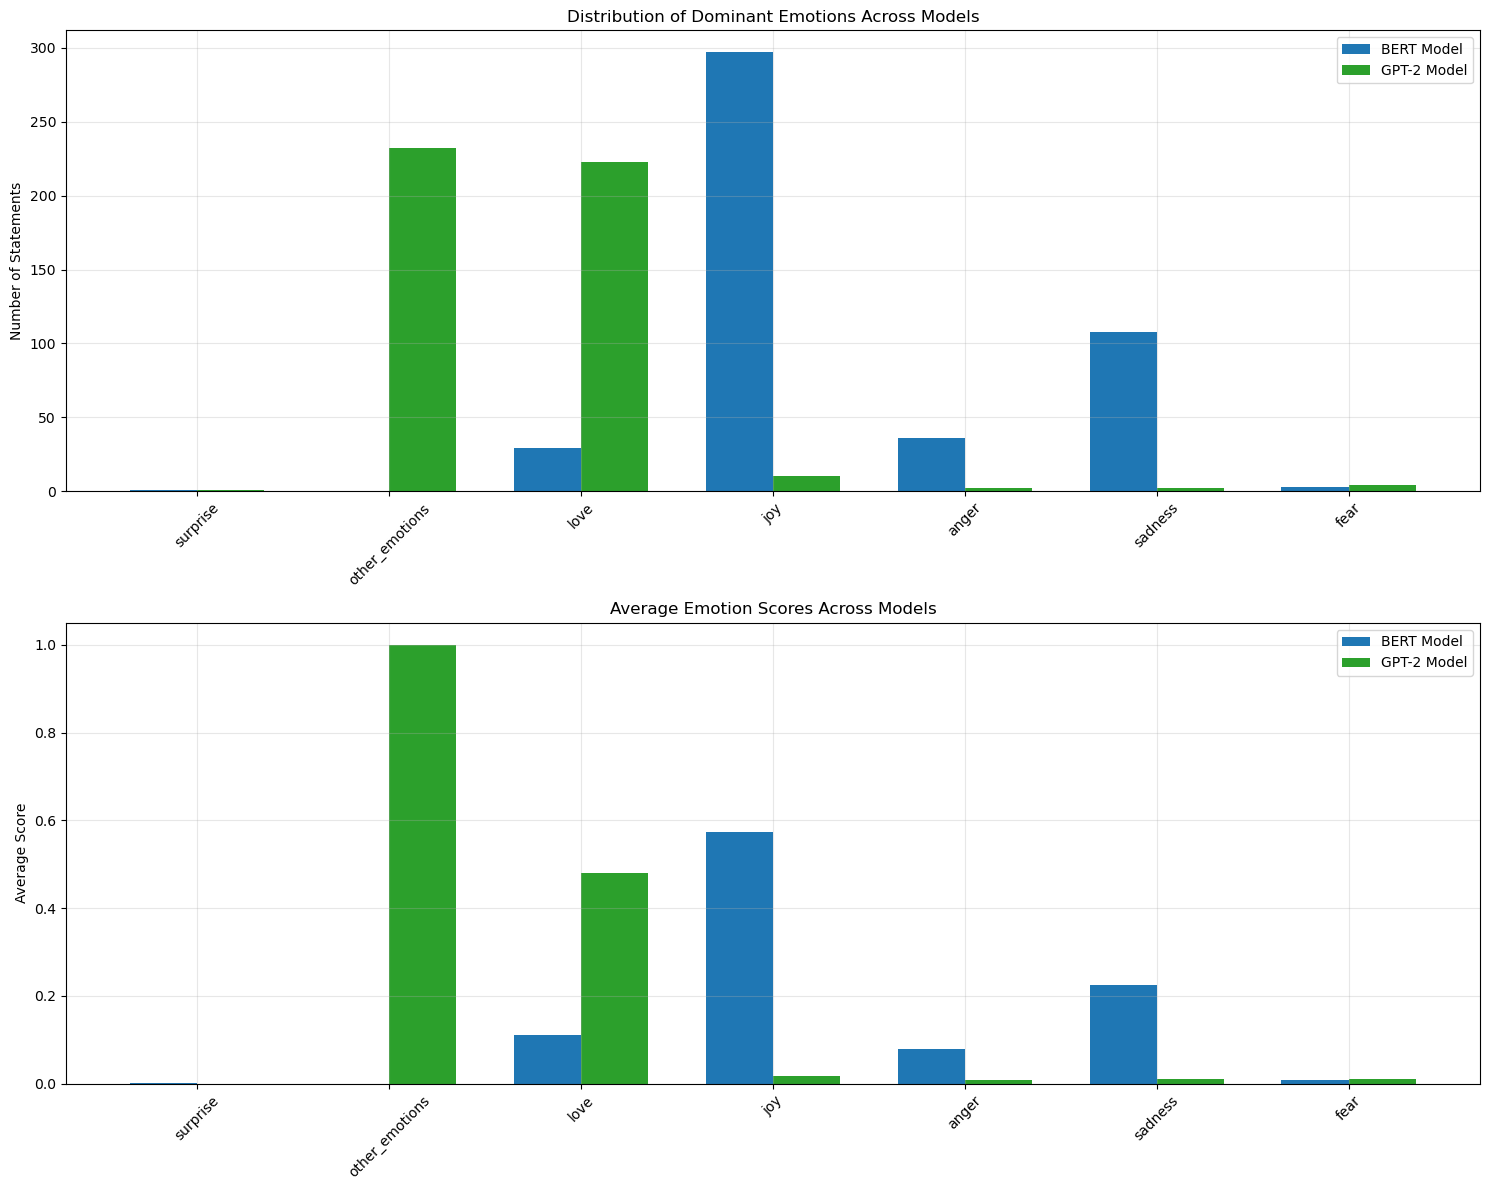

In [ ]:
bert_results = analyze_emotions_bert(df) 
gpt_results = analyze_emotions_gpt(df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# distribution comparison
bert_dist = bert_results['dominant_emotion'].value_counts()
gpt2_dist = gpt_results['dominant_emotion'].value_counts()

# get all unique emotions from both models
all_emotions = list(set(bert_dist.index) | set(gpt2_dist.index))
bert_counts = [bert_dist.get(emotion, 0) for emotion in all_emotions]
gpt2_counts = [gpt2_dist.get(emotion, 0) for emotion in all_emotions]

# plot distribution
x = range(len(all_emotions))
width = 0.35

ax1.bar([i - width/2 for i in x], bert_counts, width, label='BERT Model', color='#1f77b4')
ax1.bar([i + width/2 for i in x], gpt2_counts, width, label='GPT-2 Model', color='#2ca02c')
ax1.set_xticks(x)
ax1.set_xticklabels(all_emotions, rotation=45)
ax1.set_ylabel('Number of Statements')
ax1.set_title('Distribution of Dominant Emotions Across Models')
ax1.legend()
ax1.grid(True, alpha=0.3)

# average scores comparison
bert_emotion_cols = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
bert_avgs = bert_results[bert_emotion_cols].mean()

# get GPT-2 average scores (excluding non-emotion columns)
gpt2_emotion_cols = [col for col in results.columns if col not in ['dominant_emotion'] + list(df.columns)]
gpt2_avgs = results[gpt2_emotion_cols].mean()

# combine and plot averages
all_emotions_avg = list(set(bert_emotion_cols) | set(gpt2_emotion_cols))
bert_avgs_plot = [bert_avgs.get(emotion, 0) for emotion in all_emotions_avg]
gpt2_avgs_plot = [gpt2_avgs.get(emotion, 0) for emotion in all_emotions_avg]

ax2.bar([i - width/2 for i in x], bert_avgs_plot, width, label='BERT Model', color='#1f77b4')
ax2.bar([i + width/2 for i in x], gpt2_avgs_plot, width, label='GPT-2 Model', color='#2ca02c')
ax2.set_xticks(x)
ax2.set_xticklabels(all_emotions_avg, rotation=45)
ax2.set_ylabel('Average Score')
ax2.set_title('Average Emotion Scores Across Models')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/mt/c_88523n41z85rl9zwh25cr40000gn/T/ipykernel_42712/3721571110.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['statement_length'] = df['Last Statement'].str.len()


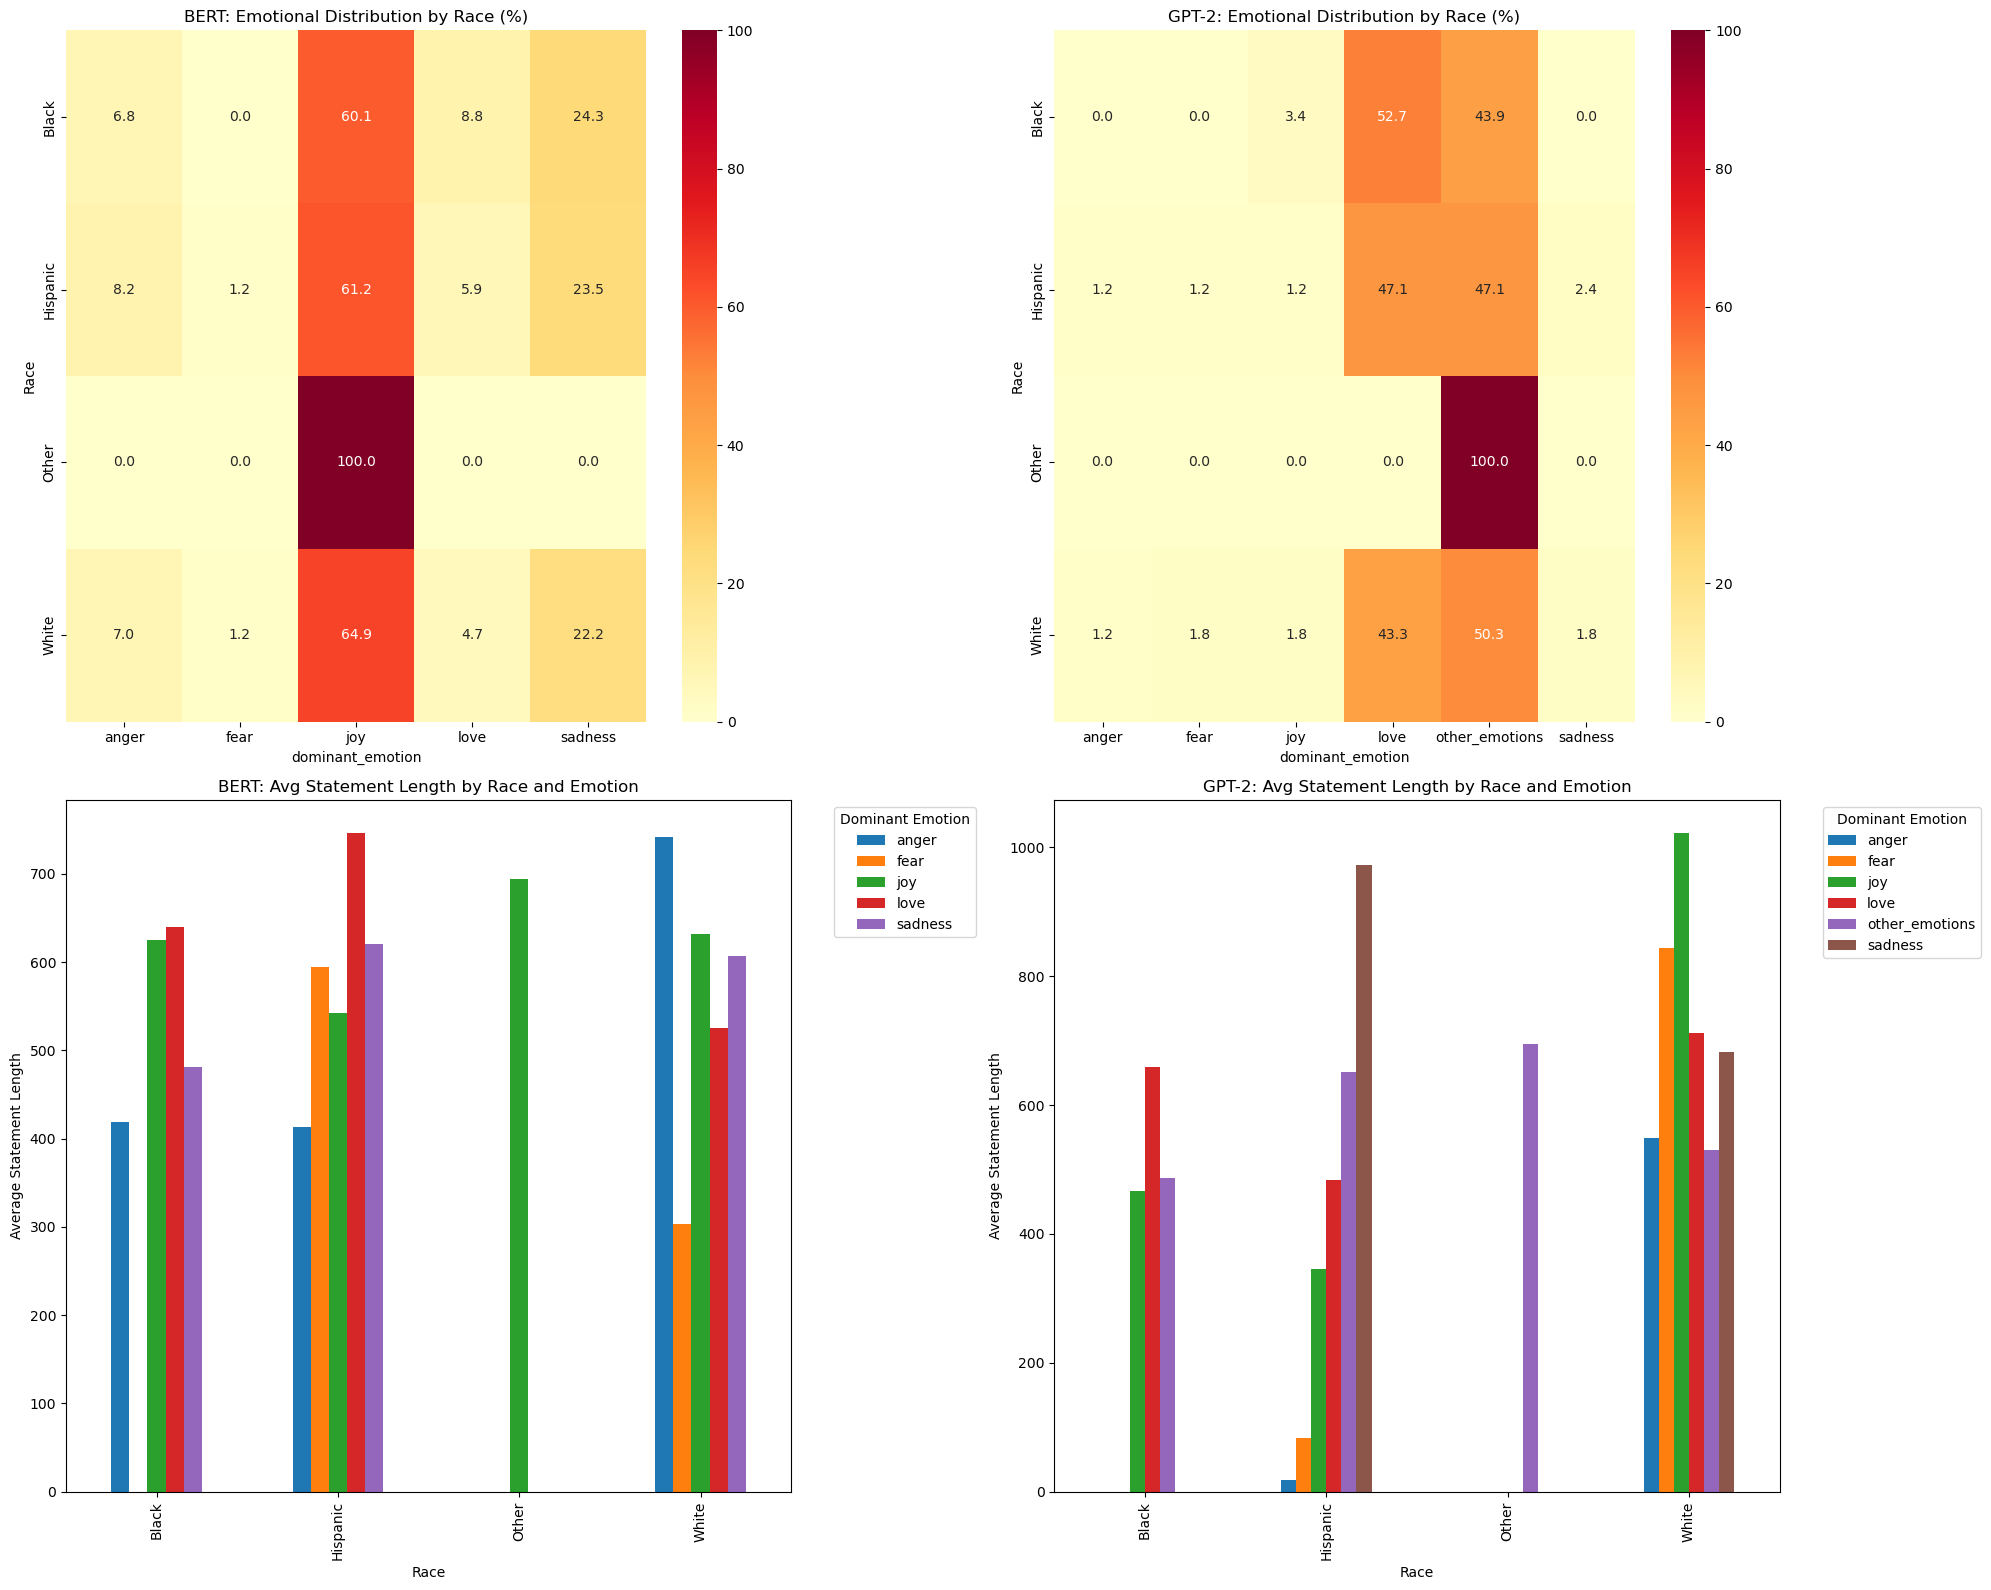


Statistical Analysis:

Average Statement Length by Race:
            mean  count     std
Race                           
Black     539.71    170  691.04
Hispanic  535.72     94  496.78
Other     600.25      4  669.96
White     558.43    206  578.14

Chi-square test for Race vs Emotions:

BERT Model:
Chi-square statistic: 6.34
p-value: 0.8981

GPT-2 Model:
Chi-square statistic: 14.33
p-value: 0.5009


In [7]:
# analyze emotions by race/ethnicity for both models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# dominant emotion by race for BERT
race_emotion_bert = pd.crosstab(df['Race'], bert_results['dominant_emotion'], normalize='index') * 100
sns.heatmap(race_emotion_bert, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1)
ax1.set_title('BERT: Emotional Distribution by Race (%)')
ax1.set_ylabel('Race')

# dominant emotion by race for GPT-2
race_emotion_gpt2 = pd.crosstab(df['Race'], results['dominant_emotion'], normalize='index') * 100
sns.heatmap(race_emotion_gpt2, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
ax2.set_title('GPT-2: Emotional Distribution by Race (%)')
ax2.set_ylabel('Race')

# average Statement length by race and dominant Emotion
df['statement_length'] = df['Last Statement'].str.len()

# BERT
bert_length_analysis = df.groupby(['Race', bert_results['dominant_emotion']])['statement_length'].mean().unstack()
bert_length_analysis.plot(kind='bar', ax=ax3)
ax3.set_title('BERT: Avg Statement Length by Race and Emotion')
ax3.set_xlabel('Race')
ax3.set_ylabel('Average Statement Length')
ax3.legend(title='Dominant Emotion', bbox_to_anchor=(1.05, 1))

# GPT-2
gpt2_length_analysis = df.groupby(['Race', results['dominant_emotion']])['statement_length'].mean().unstack()
gpt2_length_analysis.plot(kind='bar', ax=ax4)
ax4.set_title('GPT-2: Avg Statement Length by Race and Emotion')
ax4.set_xlabel('Race')
ax4.set_ylabel('Average Statement Length')
ax4.legend(title='Dominant Emotion', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# statistical analysis
print("\nStatistical Analysis:")
print("\nAverage Statement Length by Race:")
print(df.groupby('Race')['statement_length'].agg(['mean', 'count', 'std']).round(2))

# chi-square test for independence between race and emotions
from scipy.stats import chi2_contingency

print("\nChi-square test for Race vs Emotions:")
print("\nBERT Model:")
chi2, p_val, dof, expected = chi2_contingency(pd.crosstab(df['Race'], bert_results['dominant_emotion']))
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.4f}")

print("\nGPT-2 Model:")
chi2, p_val, dof, expected = chi2_contingency(pd.crosstab(df['Race'], results['dominant_emotion']))
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.4f}")